In [122]:
import pandas as pd
import os
%matplotlib inline  

In [123]:
def makeLoadDoc():
    if os.path.isfile('./data/df_doc'):
        df = pd.read_pickle('./data/df_doc')
        return df
    else:
        pass

In [124]:
#df = makeLoadDoc()

In [125]:
#df = pd.DataFrame({'sentences': sentences})

In [126]:
df = pd.read_json('./data/dfExoplanetsNASAdetected100rand_v2.json', orient = 'table')
df = df[['sent', 'label']]

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 2 columns):
sent     100 non-null object
label    100 non-null object
dtypes: object(2)
memory usage: 2.3+ KB


In [128]:
df.columns

Index(['sent', 'label'], dtype='object')

In [129]:
df['category_id'] = df['label'].factorize()[0]
from io import StringIO
category_id_df = df[['sent', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sent', 'label']].values)

In [130]:
df.head()

,sent,label,category_id
0,We detected visual companions within 1'' for 5...,discovery,0
1,Using these data and photometry from the Spitz...,discovery,0
2,"Of the over 800 exoplanets detected to date, o...",None,1
3,We find that for these false positive scenario...,discovery,0
4,We present two exoplanets detected at Keck Obs...,discovery,0


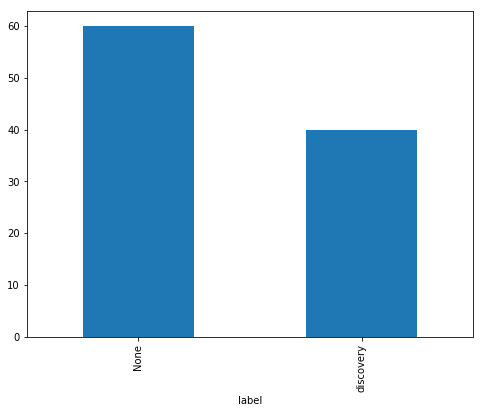

In [131]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').sent.count().plot.bar(ylim=0)
plt.show()

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.sent).toarray()
labels = df.category_id
features.shape

(100, 44)

In [133]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'A considerable change in Blazhko effect for V25 has been detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'A distinct supersoft X-ray component was also detected at optical maximum, which probably arises from an optically thick boundary layer.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'A solution to both of these problems is to use the science camera of an ExAO system as a wavefront sensor to perform a fast measurement and correction method to remove these aberrations as soon as they are detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'A variety of terrestrial planets with different physical parameters and exotic atmospheres might plausibly exist outside our Solar System, waiting to be detected by the next generation of space-exploration missions.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Aims: We present here the list of planetary transit candidates detected in the first long run observed by CoRoT: LRc01, towards the galactic center in the direction of Aquila, which lasted from May to October 2007.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Although microlensing searches have so far detected only a handful of planets, these have already changed our understanding of planet formation beyond the snow line.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'An initial census of large ring systems can be carried out using high-precision follow-up observations of detected transits and by the upcoming NASA Kepler mission.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Based on previous ground-based cometary observations, this was an unexpected finding, as was the significant amount of O2 detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Brigham Young University (BYU) has been assisting in the ground-based follow-up of extrasolar planet candidates detected by the KELT telescope using our 0.4-meter and 0.9-meter telescopes.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Combining these instruments with powerful telescopes, astronomers have detected thousands of exoplanets.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Differential astrometry measurements from the Palomar High-precision Astrometric Search for Exoplanet Systems (PHASES) are used to constrain the astrometric orbit of the previously known lsim2 day subsystem in the triple system 63 Gem A and have detected a previously unknown two-year Keplerian wobble superimposed on the visual orbit of the much longer period (213 years) binary system HR 2896.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Finally, the planet-star contrast must exceed a certain minimum value in order for the planet to be detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'For 759 exoplanets detected by radial velocities method we found that distances of exoplanets from central star comply in general Schmidt law and these distances depend on the stellar surface temperature.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'For the closest planets detected so far ( ≲ 0.05 AU), the effect on the radius is of the order of 1 to 10%, by no means a negligible effect, enhancing the puzzling problem of the anomalously large bloated planets.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Furthermore, our analysis indicates that C_2H_2 is the major absorber in the atmosphere of WASP-12b and the absorption features detected near 1.6 and 8':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'GJ 832b has the second largest angular distance from its star among radial velocity detected exoplanets (0.69 arcsec) making it a potentially interesting target for future direct detection.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Given high metallicity, and the trend indicating that multiple systems are rich in low-mass companions, this system is likely to host additional low-mass planets in its habitable zone that can be readily detected with state-of-the-art optical and near-infrared RV measurements.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Ground- and space-based planet searches employing radial velocity techniques and transit photometry have detected thousands of planet-hosting stars in the Milky Way.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Here we present a catalog of 164 single transit and eclipse candidates detected during a comprehensive survey of all currently available K2 data.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Horologii is quite extended; it is detected to a distance of about 65 AU, i.e. 10,000 million km, from the star.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'If a roughly Earth-sized, Earth-mass moon would be detected in orbit around a giant planet, and if the planet-moon duet would orbit in the stellar HZ, then it will be crucial to recover the orbital history of the moon.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'If the two-planet model is true, then this is the third multiple-planet system detected using the microlensing method and the first multiple-planet system detected in low-magnification events, which are dominant in the microlensing survey data.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Images were taken at a minimum of two observation epochs to check whether detected companion candidates are co-moving with the primary stars.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'In addition, a substantial number of variable stars have been detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'In the case of HD 142245, we found evidence that the detected companion is actually a close binary itself with a projected separation of only about 4 au, i.e. HD 142245 might be a hierarchical triple stellar system, which hosts an exoplanet, a new member in the short list of such systems, presently known.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'In the last decade, the number of detected exoplanets has increased to over thousand confirmed planets and more as yet unconfirmed planet candidates.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'In this framework, asteroseismic studies represent an excellent tool to determine the structural differences between stars with and without detected planets.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'In this work, we present our statistical analysis of the outliers thus detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Intranight variability was not detected from all of these light curves.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Just two of 10 extrasolar planets found by microlensing have been detected by the planetary caustic, despite the higher probability of planet detection relative to the central caustic, which has been responsible for four extrasolar planet detections.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Kepler has detected numerous exoplanet transits by measuring stellar light in a single visible-wavelength band.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Kepler-47 is the first multi-body circumbinary planetary system detected by the Kepler space telescope.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Likewise, Ganymede observations were attempted at 3.6 μm by the Spitzer Space Telescope, but it was not detected, suggesting a significant wavelength dependence.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Nearly all of the 100 plus extrasolar planets discovered to date have been detected via precise (3--6 m s^-1) radial velocity measurements of solar-type stars.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'No absorptions are detected for other lines.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'No multiplets were detected leaving EC 01541-1409 as yet another rich p-mode sdB pulsator without these features, limiting observational constraints on pulsation modes.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Of the 1919 main-sequence exoplanet hosts analyzed, robust rotation periods were detected for 737.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'On July 16, 2009, we detected a 3σ emission whose light curve is consistent with an eclipse when the planet passed behind the star.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Our historical monitoring has detected high-velocity spectral features (~13,000 km s^-1) in 2011 September, one year before the current SN-like event.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Our results can thus be used to constrain the icy/volatile phase composition of cold planets evidenced by microlensing surveys, hypothetical ocean planets, and carbon planets, which could be detected by COROT or Kepler.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Our work addresses analysis of stellar reflex motion data, where a planet is detected by observing the "wobble" of its host star as it responds to the gravitational tug of the orbiting planet.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Over 100 extrasolar planets have been already detected, the vast majority of which by radial velocity measurements.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Planets lying in this zone are then more easily detected with the radial-velocity method [3], the most successful in detecting exoplanets.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Shadows have been detected in several protoplanetary disks, suggesting that misalignment in disks is not uncommon.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Since this is the first planet detected orbiting a fast rotating star, the uncertainties in both the radial-velocity measurements and the planetary mass are larger than for most other planets discovered to date.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Subsequently, the number of planets detected by microlensing is increasing.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Supplemental slit-scanning spectroscopy using adaptive optics was performed within 0.38" of HD 141569A to search for extended emission from H^+_3, but no emission was detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The 2004 flux density was 0.05 Jy, about an order of magnitude lower than the single 2003 burst and the five bursts detected in 2002.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The DCO^+ line is detected in the HD 169142 disk with a total integrated line flux of 730 ± 73 mJy km s^-1.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The PLATO space-based data will be complemented by ground-based follow-up observations, in particular very precise radial velocity monitoring, which will be used to confirm the planetary nature of the detected events and to measure the planet masses.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The VIRT has begun reacting autonomously to the gamma-ray coordinates network (GCN) alerts in 2017 and, despite the challenges presented to the Caribbean region by hurricanes Irma and Maria, was a participant in the follow-up campaign of GW170817, the first source simultaneously detected in gravitational waves and electromagnetic waves.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The analysis of the combined HIRES/HARPS data again only reliably detected the 5.37 and 12.9 d periods.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The combined spectrum is very different from the predictions of cloud-free models for hot Jupiters: it is dominated by Rayleigh scattering over the whole visible and near-infrared range, the only detected features being narrow sodium and potassium lines.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The debris disk of HIP 73145 has been detected in scattered light in the near-IR, and at far-IR wavelengths before, but no substructure has been seen so far.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The detected induced magnetic field infers a saline ocean layer.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The detected planets shepherd the outer cool debris belt.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The detected signals are dominated by events with relatively low signal-to-noise ratios and by events with relatively short periods.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The instrument uses two emCCD cameras providing simultaneous dual-color observations help to characterize detected companions.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The observing campaigns presented here reveal no pulsations other than the initially detected frequency.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The orbital companion of Fomalhaut, Fomalhaut b, is detected in multi-color, coronagraphic observations acquired with the Hubble Space Telescope using the high-resolution channel of the Advanced Camera for Surveys.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The pre-transit signal is again detected in the Balmer lines but with variable strength and timing, suggesting that the bow shock geometry reported in our previous work does not describe the signal from the latest transit.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The presence of the close-in massive planet could also be an interpretation for the high level of stellar activity detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The properties of the detected systems are described, emphasizing 1) the questions set by the peculiarities of the new planets (large mass, large eccentricity, small separation) and the proposed answers and 2) the first statistical trends pointed out from the sample gathered so far (clear different formation processes for planet and binaries from the planetary mass and orbital-element distributions, the high metal content of stars hosting planets).':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The spectral type is estimated to be M7 (̃2700 K), and thus no methane absorption is detected in the H band.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The structures detected at millimeter wavelengths could be gaps in the distributions of large grains on the disk midplane caused by planets not massive enough to fully open the gaps.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'The transmission signal of oxygen from an Earth-twin orbiting a small red dwarf star is only a factor of three smaller than that of carbon monoxide recently detected in the hot Jupiter τ Boötis b, albeit such a star will be orders of magnitude fainter.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'These exotic stars have a binary frequency of (at least) 80%, more than three times that detected for stars in the remainder of the sample.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'This disfavours the possibility of GI-caused spiral structure in systems with q&lt;0.25 being detected in relatively short integration times, such as those found in the DSHARP ALMA survey (Andrews et al. 2018; Huang et al. 2018).':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'This provokes the question of whether exoplanets have aurorae, and whether their aurorae can be detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'This statement is supported by a figure given in the article, which shows a primary signal with a depth of 6 mmag, detected with 4σ confidence and a possible secondary signal with a depth of 2 mmag.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Using design reference missions and other simulations, we explore the potential of TPF-O to find planets in the habitable zone around their central stars, to spectrally characterize the atmospheres of detected planets, and to obtain rudimentary information about their orbits.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Using the cumulative catalog of planets detected by the NASA Kepler mission, we reconstruct the intrinsic occurrence of Earth- to Neptune-size (1-4 R _⊕) planets and their distributions with radius and orbital period.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new candidate transitional, evolved, evolved transitional, and debris disks.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We also discuss the usefulness of this method given that some planets might be not detected, but still affect the overall stability of the system.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We detected a p.d.f. pattern that represents an upturn followed by an overshooting peak spanning P̃':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We detected four out-of-transit u’ band events consistent with stellar flares.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We detected possible periodic variations in the duration of the exoplanet transit across the stellar disk with time for HAT-P-12b that could be caused by variations in orbital inclination.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We find that a close-in Jupiter-like planet orbiting at 0.05 AU presents a radio power that is ~5 orders of magnitude larger than the one observed in Jupiter, which suggests that the stellar wind from a young star has the potential to generate strong planetary radio emission that could be detected in the near future with LOFAR.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star with as few as 10 transits, assuming photon-limited noise.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We find that stellar wind drag can dominate the circumstellar grain removal and plausibly explain the dearth of M dwarf systems older than 10 Myr with currently detected infrared excesses.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We find that such objects can feasibly be detected by a ground-based transit survey if their formation frequency is high and if correlated noise can be controlled to sub-milli-magnitude levels.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We found that about half the stars are too faint for the granulation background to be reliably detected above the white noise.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We further discuss a speckle subtraction and suppression technique that fully takes advantage of spectral and time-domain information on quasi-static speckles to measure the highest-fidelity photometry as well as accurate astrometry of detected companions.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We have detected and confirmed radio flares from the T6.5 dwarf':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We have detected rotation in seven dM1e stars and 11 dM1 stars and upper limits for 20 other dM1 stars.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We have detected the surface magnetic field as circularly polarized signatures in the 819 nm sodium lines when an active emission region faced the Earth.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We measure the flux of the four stellar emission features detected in the COS spectrum (C II, C III, C IV, Si IV).':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We present the discovery of two planetary systems consisting of a Saturn-mass planet orbiting an M-dwarf, which were detected in faint microlensing events OGLE-2013-BLG-0132 and OGLE-2013-BLG-1721.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We present two exoplanets detected at Keck Observatory.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We report absorption in atomic magnesium (Mg i), while no signal has been detected in the lines of singly ionized magnesium (Mg ii).':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We report the discovery of six new substellar companions of main-sequence stars, detected by multiple Doppler measurements with the instrument HARPS installed on the ESO 3.6m telescope, La Silla, Chile.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'We searched for a transit signature of HD 77338b but none was detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'While the discovery of α Cen Bb has shown that terrestrial planets can be detected in solar-type binary stars using current observational facilities, it remains to be shown whether this is also the case for Earth analogs in HZs.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'While the original Kepler mission detected systems with up to seven planets, K2 had yet to detect systems with more than three candidates until now.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'With the rapid developments in the exoplanet field, more and more terrestrial exoplanets are being detected.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'arXiv:1006.2815) is being continuously augmented as more data are collected and EBs are detected at longer periods.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 'giant planet at ∼0.5 AU, but HD 80607 has no detected planets.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# '≲20 M _Jup possess actively accreting subdisks detected via Paβ line emission, which represents a lower limit on the prevalence of circumplanetary disks in general, as some are expected to be in a quiescent phase of accretion.':
  . Most correlated unigrams:
       . using
       . velocity
  . Most correlated bigrams:
       . planets detected
       . radial velocity


In [134]:
feature_names

array(['10', 'observations', 'orbital', 'orbiting', 'planet', 'planetary',
       'planets', 'planets detected', 'present', 'near', 'radial',
       'signal', 'space', 'star', 'stars', 'stellar', 'systems',
       'telescope', 'transit', 'radial velocity', 'microlensing',
       'method', 'measurements', 'au', 'based', 'candidates',
       'companions', 'data', 'detected', 'dwarf', 'earth', 'emission',
       'events', 'exoplanet', 'exoplanets', 'features', 'ground', 'hd',
       'high', 'kepler', 'lines', 'mass', 'using', 'velocity'],
      dtype='<U16')

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['sent'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [136]:
print(clf.predict(count_vect.transform([df.sent[0]])))

['discovery']


In [137]:
print(clf.predict(count_vect.transform([df.sent[20]])))

['None']


In [138]:
df[df['sent'] == df.sent[0]]

,sent,label,category_id
0,We detected visual companions within 1'' for 5...,discovery,0


In [139]:
df[df['sent'] == df.sent[20]]

,sent,label,category_id
20,The structures detected at millimeter waveleng...,None,1


In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

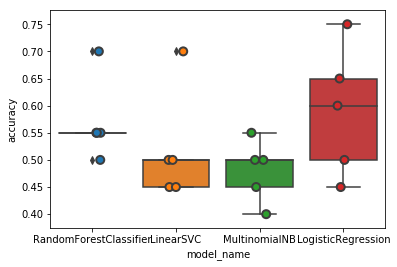

In [141]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [142]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.52
LogisticRegression        0.59
MultinomialNB             0.48
RandomForestClassifier    0.57
Name: accuracy, dtype: float64

In [143]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

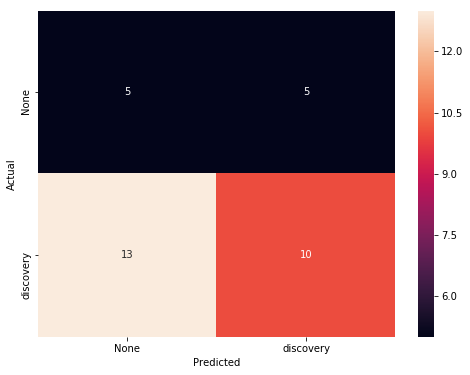

In [144]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(set(category_id_df.label.values)), yticklabels=list(set(category_id_df.label.values)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [145]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'sent']])
            print('')

AttributeError: 'DataFrame' object has no attribute 'category_id'

In [147]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [148]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [149]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."


KeyError: 1

In [151]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['label'].unique()))

              precision    recall  f1-score   support

   discovery       0.28      0.50      0.36        10
        None       0.67      0.43      0.53        23

   micro avg       0.45      0.45      0.45        33
   macro avg       0.47      0.47      0.44        33
weighted avg       0.55      0.45      0.48        33

